In [46]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d

In [47]:
# LOAD in fixed simulation parameters
sim_z = np.loadtxt('/Users/kulkarniad/muram/z.csv')
NLAMBDA = 472
NZ = 64
NX = 50
NY = 50

In [3]:
# Create collision depolarization cube.
def load_depol_array():
    data = pd.read_csv('depol.csv') # copy of Figure 6 of aleman and trujillo bueno
    z = data.iloc[:,0]*1e3 # z is in units of km
    delta = data.iloc[:,1] # delta is unitless
    delta_interp = interp1d(z,delta,fill_value= 'extrapolate')
    delta_array = delta_interp(sim_z)
    delta_cube = np.zeros((NZ,NY,NX))
    # Interpolate this function over MURaM z values
    for i in range(NX):
        for j in range(NY):
            delta_cube[:,j,i] = delta_array
    return delta_cube

In [4]:
delta_cube = load_depol_array()

Text(0.5, 0, '$z (km) $')

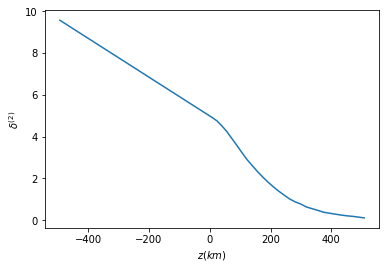

In [5]:
plt.plot(sim_z,delta_cube[:,0,0])
plt.ylabel('$\delta ^{(2)}$')
plt.xlabel('$z (km) $')

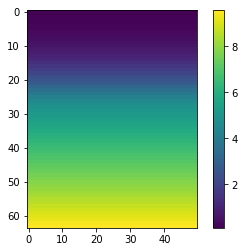

In [6]:
plt.imshow(delta_cube[:,:,32])
plt.colorbar()

In [7]:
# READ IN OPACITIES AND EMISSIVITIES
data = fits.open('small/opac_l.fits')
opac_l = data[0].data
data = fits.open('small/opac_c.fits')
opac_c = data[0].data

data = fits.open('small/emis_l.fits')
emis_l = data[0].data
data = fits.open('small/emis_c.fits')
emis_c = data[0].data

In [8]:
S_l = emis_l/opac_l

In [9]:
#GLOBAL VARIABLES
NX = 50
NY = 50
NZ = 64
TRT = 2.0*np.sqrt(2) # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji note that this is a factor 5 different from NIST's value

In [10]:
class Opacity:
    def __init__(self,dir_loc):        
        data = fits.open(dir_loc+'opac_l.fits')
        self.opac_l = data[0].data
        data = fits.open(dir_loc+'opac_c.fits')
        self.opac_c = data[0].data

        data = fits.open(dir_loc+'emis_l.fits')
        self.emis_l = data[0].data
        data = fits.open(dir_loc+'emis_c.fits')
        self.emis_c = data[0].data
            

In [11]:
def epsilon(dir_loc):
    cij = np.loadtxt(dir_loc+'Cij8.txt').reshape(NZ,NY,NX)
    return cij/(cij+Aij)
    

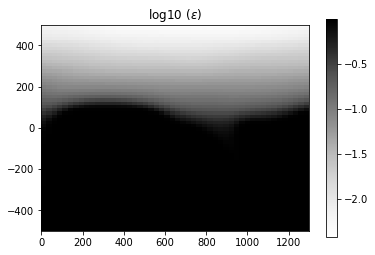

In [12]:
eps_small = epsilon('small/')

plt.imshow(np.log10(eps_small[:,10,:]),cmap='Greys',extent=[0,1300,-500,500])
plt.colorbar()
plt.title('log10 ($ \epsilon $)')
plt.show()

$\varepsilon$ ranges from $\sim 1$ down low in the atmosphere to less than $0.01$ near the top of the atmosphere

In [13]:
sorted(glob.glob('small/'+'/*txt'))

['small/Cij8.txt',
 'small/J.txt',
 'small/J20.txt',
 'small/imJ21.txt',
 'small/imJ22.txt',
 'small/reJ21.txt',
 'small/reJ22.txt']

In [14]:
class Sphr_tensors:
    def __init__(self,dir_loc):
        # spherical J tensors
        self.j00 = np.loadtxt(dir_loc+'J.txt').reshape(NZ,NY,NX)
        self.j20 = np.loadtxt(dir_loc+'J20.txt').reshape(NZ,NY,NX)
        self.imj21 = np.loadtxt(dir_loc+'imJ21.txt').reshape(NZ,NY,NX)
        self.imj22 = np.loadtxt(dir_loc+'imJ22.txt').reshape(NZ,NY,NX)
        self.rej21 = np.loadtxt(dir_loc+'reJ21.txt').reshape(NZ,NY,NX)
        self.rej22 = np.loadtxt(dir_loc+'reJ22.txt').reshape(NZ,NY,NX)

In [15]:
class Source_function:
    def __init__(self,dir_loc):

        st = Sphr_tensors(dir_loc)       
        eps = epsilon(dir_loc)
        delta = load_depol_array()
        
        opcty = Opacity(dir_loc)        
        self.r = opcty.opac_l / (opcty.opac_l  + opcty.opac_c )
        self.source_l = opcty.emis_l/opcty.opac_l
        self.source_c = opcty.emis_c/opcty.opac_c
    
        self.s00 = self.source_l # define this to be the line source function
        self.s20 = (1-eps)/(1+delta*(1-eps)) * st.j20
        self.ims21 = (1-eps)/(1+delta*(1-eps)) * st.imj21 * (-1.0)
        self.ims22 = (1-eps)/(1+delta*(1-eps)) * st.imj22 * (-1.0)
        self.res21 = (1-eps)/(1+delta*(1-eps)) * st.rej21
        self.res22 = (1-eps)/(1+delta*(1-eps)) * st.imj22        
        
    # Line source functions
    def si_line(self,mu,azi):
        c1 = 1/TRT*(3*mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1-mu**2)        

        out = self.s00 + c1*self.s20 \
        - c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) \
        + c3*(self.res22*np.cos(2*azi) - self.ims22*np.sin(2.0*azi)) 

        return out
    
    def sq_line(self,mu,azi):
        c1 = 3/TRT*(mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1+mu**2)

        out = c1*self.s20 \
        -c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) \
        -c3*(self.res22*np.cos(2*azi)-self.ims22*np.sin(2*azi))
        return out

    def su_line(self,mu,azi):
        c1 = np.sqrt(1-mu**2)
        
        out = c1*(self.res21*np.sin(azi) + self.ims21*np.cos(azi)) \
        + mu*(self.res22*np.sin(2*azi) + self.ims22*np.cos(2*azi))

        out *= np.sqrt(3.0)
        return out
    
# Now Calculate source functions of I, Q U:         
    def source_i(self,mu,azi):
        return self.r*self.si_line(mu,azi) + (1-self.r)*self.source_c

    def source_q(self,mu,azi):
        return self.r*self.sq_line(mu,azi)  # check that some wierd broadcasting is not going on here!

    def source_u(self,mu,azi):
        return self.r*self.su_line(mu,azi) 

Source funcs are loaded and ready to rumble!

###  Now try and solve radiative transfer eqn:

In [16]:
total_opac = opac_l+opac_c
from scipy.integrate import cumtrapz


In [17]:
# calculate tau by intergrating opacity
tau_cube = np.zeros((NLAMBDA,NZ,NY,NY))
for l in range(NLAMBDA):
    for i in range(NX):
        for j in range(NY):
            tau_cube[l,:,j,i] = np.log10(cumtrapz(total_opac[l,:,j,i], x=sim_z*1e3,initial=-1e6) * (-1.0))
            

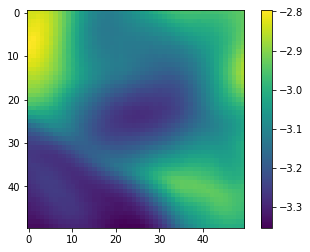

In [18]:
plt.imshow(tau_cube[0,2])
plt.colorbar()

In [19]:
total_opac.shape

(472, 64, 50, 50)

In [21]:
src_fnc = Source_function('small/')

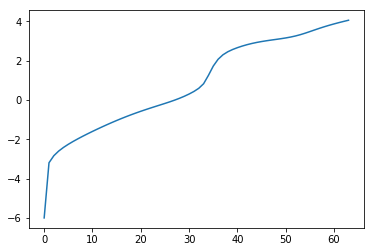

In [22]:
plt.plot(np.log10(-tau))

In [30]:
src_fnc.source_i(0.0,0.0).shape

(472, 64, 50, 50)

In [31]:
# FORMAL solver for vertical rays

def sc_formal_solver(I_upwind,delta,S_upwind,S_local):
 
    expd = np.exp(-delta)
    w_local = 1.0 - 1.0/delta * (1.0 - expd)
    w_upwind = -expd + 1.0/delta * (1.0 - expd)
 
    I_local = I_upwind * expd + w_local * S_local + w_upwind * S_upwind
 
    return I_local

In [32]:
sc_formal_solver(1,0.1,1,2)

1.0483741803595952

In [36]:
I_cube = np.zeros((NLAMBDA,NZ,NY,NY))
src_fnc = Source_function('small/')
S = src_fnc.source_i(1.0,0.0)
I_cube[:,NZ-1,:,:] = S[:,NZ-1,:,:]
for l in range(NLAMBDA):
    for j in range(NY):
        for i in range(NX):
            for d in list(range(NZ-2,-1,-1)):
                dtau = 10**tau_cube[l,d+1,j,i] - 10**tau_cube[l,d,j,i]
                I_cube[l,d,j,i] = sc_formal_solver(I_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])

/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


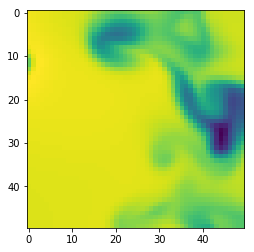

In [39]:
plt.imshow(I_cube[0,61,:,:])

In [40]:
Q_cube = np.zeros((NLAMBDA,NZ,NY,NY))
src_fnc = Source_function('small/')
S = src_fnc.source_q(1.0,0.0)
Q_cube[:,NZ-1,:,:] = S[:,NZ-1,:,:]
for l in range(NLAMBDA):
    for j in range(NY):
        for i in range(NX):
            for d in list(range(NZ-2,-1,-1)):
                dtau = 10**tau_cube[l,d+1,j,i] - 10**tau_cube[l,d,j,i]
                Q_cube[l,d,j,i] = sc_formal_solver(Q_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])

/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/neku5162/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


KeyboardInterrupt: 

Comparing magnitude of the terms:

In [ ]:
st = Sphr_tensors('small/')

In [58]:
st.j00.shape

(64, 50, 50)

In [53]:
src_fnc.s20

array([[[ 2.16534943e-15,  2.25542484e-15,  2.37244347e-15, ...,
          1.78667317e-15,  1.85144845e-15,  1.89243371e-15],
        [ 2.16734750e-15,  2.26735719e-15,  2.43382390e-15, ...,
          1.77901150e-15,  1.83170563e-15,  1.87053567e-15],
        [ 2.15213504e-15,  2.29170140e-15,  2.46236026e-15, ...,
          1.74704390e-15,  1.79676074e-15,  1.82507698e-15],
        ...,
        [ 1.32904342e-15,  1.37859001e-15,  1.42047181e-15, ...,
          1.77937117e-15,  1.82333276e-15,  1.84062898e-15],
        [ 1.31458845e-15,  1.35776242e-15,  1.41367935e-15, ...,
          1.73809978e-15,  1.77082222e-15,  1.80220019e-15],
        [ 1.30191214e-15,  1.34695405e-15,  1.40206692e-15, ...,
          1.70102814e-15,  1.75121448e-15,  1.76776668e-15]],

       [[ 2.39548669e-15,  2.49035552e-15,  2.65180077e-15, ...,
          1.92933560e-15,  2.01587281e-15,  2.08363574e-15],
        [ 2.38715259e-15,  2.52501000e-15,  2.72029921e-15, ...,
          1.92944306e-15,  2.00613941e

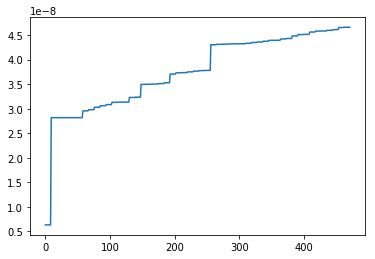

In [52]:
plt.plot(src_fnc.s00[:,28,0,0])

In [48]:
src_fnc.s00.shape

(472, 64, 50, 50)

Analyze scattering polarization in Line core!

In [ ]:
plt.plot(I_cube[:,1,0,0])

- tau_cube needs to depend on directory


In [67]:
# Compute planck function for scale in SI units:
def B(v,t):
    
    h=6.62607015e-34
    c = 3e8
    kb = 1.380649e-23
    
    out = 2*h*v**3/c**2
    e = h*v/(kb*t)
    out = out/(np.exp(e) - 1 )
    return out  # units are Watts. Sr^-1.m^-2.Hz-1

In [71]:
B((3e8)/(500e-9),6000) # planck function at 6000 K at 500 nm

2.6412173022356238e-08

Hence, we expect intensities to be on the order of $10^{-8}$

In [62]:
B(400e-9,6000)

[28970198047849.75, 1.5450772292186534e-08]

In [ ]:
st = Sphr_tensors('small/')

In [ ]:
plt.semilogy(sim_z,st.j20[:,0,0]/st.j00[:,0,0],label = 'J00')
plt.xlabel('z (km)')
plt.legend()
plt.show()

In [ ]:
plt.semilogy(sim_z,st.j00[:,0,0],label = 'J00')
plt.semilogy(sim_z,st.j20[:,0,0],label = 'J20')
plt.xlabel('z (km)')
plt.legend()
plt.show()

In [ ]:
plt.plot(src_fnc.s00[:,20,0,0])

In [ ]:
plt.semilogy(sim_z,st.j00[:,0,0],label = 'J00')
plt.semilogy(sim_z,src_fnc.s00[1,:,0,0],label = 'S00')
plt.xlabel('z (km)')
plt.legend()
plt.show()

In [ ]:
plt.semilogy(sim_z,(src_fnc.s00[37,:,0,0]), label = 's00 = [opac_l/emis_l]')
plt.semilogy(sim_z,(src_fnc.s20[:,0,0]), label = 's20')
plt.legend()
plt.xlabel('z (km)')
plt.show()

In [ ]:
plt.plot(src_fnc.s20[:,0,0])
plt.plot(st.j20[:,0,0])

In [ ]:
plt.plot(src_fnc.sq_line(1.0,0.0)[:,0,0])

In [ ]:
plt.plot(src_fnc.r[:,20,0,0])

In [ ]:
plt.semilogy(src_fnc.source_i(1.0,0.0)[37,:,0,0])
plt.semilogy(src_fnc.source_q(1.0,0.0)[38,:,0,0])
plt.semilogy(src_fnc.source_u(1.0,0.0)[37,:,0,0])

In [ ]:
np.max(I_cube[18,1,:,:])

In [ ]:
np.max(Q_cube[18,1,:,:])

In [ ]:
plt.plot(Q_cube[4:80,1,0,0])

In [ ]:
np.argmax(Q_cube[:,1,0,0])

In [ ]:
plt.imshow(Q_cube[37,1,:,:]/I_cube[37,1,:,:],cmap='bwr')
plt.colorbar()

In [ ]:
i_list = np.zeros(64)
i_list[-1] = S_col[-1]
for d in list(range(62, 0,-1)):
    dtau = 10**tau[d+1] - 10**tau[d]
    i_list[d] = sc_formal_solver(i_list[d+1],dtau,S_col[d+1],S_col[d])

In [ ]:
plt.plot(i_list)

In [ ]:
list(range(62, 0,-1))

In [ ]:
i_list = np.zeros(64)

In [ ]:
plt.plot(np.log10(tau*-1.0))

In [24]:
total_opac.shape

(472, 64, 50, 50)

In [25]:
tau = -1.0*np.cumsum(total_opac[0,:,0,0] * np.gradient(sim_z)*(1e3))

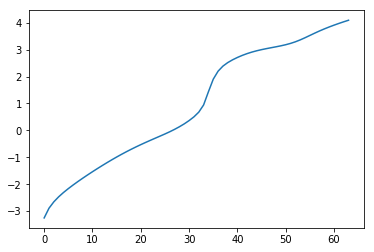

In [26]:
plt.plot(np.log10(tau))

In [27]:
np.log10(tau)

array([-3.25303302, -2.8922116 , -2.6558188 , -2.46925096, -2.30918132,
       -2.16453449, -2.02908365, -1.89996148, -1.77556413, -1.65490003,
       -1.53730802, -1.42242195, -1.31019537, -1.20084531, -1.094596  ,
       -0.99161735, -0.89214165, -0.79638772, -0.70441623, -0.61601534,
       -0.53097685, -0.44890278, -0.36918899, -0.29085743, -0.21307409,
       -0.13429328, -0.0518625 ,  0.03721531,  0.13433143,  0.24147493,
        0.36284647,  0.5011343 ,  0.67570451,  0.94287276,  1.43400494,
        1.90079511,  2.19799768,  2.38592078,  2.51706003,  2.62018039,
        2.70791593,  2.78437548,  2.85063717,  2.90752427,  2.95623133,
        2.99828565,  3.03555037,  3.07007412,  3.10418343,  3.14037468,
        3.18136733,  3.23013354,  3.2894131 ,  3.36035167,  3.44075971,
        3.52584466,  3.61089804,  3.69257768,  3.769237  ,  3.84084242,
        3.90808221,  3.97173001,  4.03241543,  4.09021196])

In [28]:
dir_loc = 'small/'

In [29]:
source_funcs = Source_function(dir_loc)

In [350]:
source_funcs.source_q(1.0,0.0).shape

(472, 64, 50, 50)

# TODO:
- Make sure things line up in the bottom of the atmosphere (J = B = I)